In [1]:
%matplotlib inline
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib.tri import Triangulation, TriAnalyzer, UniformTriRefiner
import matplotlib.animation as animation
import matplotlib.cm as cm
import matplotlib.ticker as ticker
import matplotlib
import netCDF4
import gridded.pyugrid as pyugrid
import cartopy
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import shapefile

# Python library that can read unstructured grid subclassed from pygrid
# to handle a few nonstandard features in dflowfm netCDF files
#PACKAGE_PARENT = '.'
#SCRIPT_DIR = os.path.dirname(os.path.realpath(os.path.join(os.getcwd(), os.path.expanduser(__file__))))
#sys.path.append(os.path.normpath(os.path.join(SCRIPT_DIR, PACKAGE_PARENT)))

import d3d_fm_ugrid
import read_nc_cdf
import streamplot_ug


class NcMapD3dfm(read_nc_cdf.NcCdf):
    '''
    Class encapsulating the Delft3D-FM netCDF MAP file features and plotting
    '''

    # plot:0 = no plotting; 1 = plot as a map, 2 = plot as a map with one arg, 3 = plot the mesh,
    #                       4 = plot statistics such as number of nodes, 5 = plot stat with arg
    # FixME: old variables, will be removed
    old_variable_dicts = [
        {'Name': 'BndLink', 'standard': '', 'long': 'Netlinks that compose the net boundary', 'plot': 4},
        {'Name': 'FlowElemContour_x', 'standard:': 'projection_x_coordinate',
         'long': 'List of x-points forming flow element', 'plot': 2},
        {'Name': 'FlowElemContour_y', 'standard': 'projection_y_coordinate',
         'long': 'List of y-points forming flow element', 'plot': 2},
        {'Name': 'FlowElem_bac', 'standard': 'cell_area', 'long': 'Flow element area', 'plot': 1},
        {'Name': 'FlowElem_bl', 'standard': 'sea_floor_depth', 'long': "Bottom level at flow element's circumcenter.",
         'plot': 1},
        {'Name': 'FlowElem_xcc', 'standard': 'projection_x_coordinate', 'long': 'Flow element circumcenter x',
         'plot': 1},
        {'Name': 'FlowElem_ycc', 'standard': 'projection_y_coordinate', 'long': 'Flow element circumcenter y',
         'plot': 1},
        {'Name': 'FlowElem_zcc', 'standard': '', 'long': 'Flow element average bottom level (average of all corners).',
         'plot': 1},
        {'Name': 'FlowLink', 'standard': '', 'long': 'link/interface between two flow elements', 'plot': 0},
        {'Name': 'FlowLinkType', 'standard': '', 'long': 'type of flowlink', 'plot': 0},
        {'Name': 'FlowLink_latu', 'standard': 'latitude', 'long': 'flowlink latitude', 'plot': 0},
        {'Name': 'FlowLink_lonu', 'standard': 'longitude', 'long': 'flowlink longitude', 'plot': 0},
        {'Name': 'FlowLink_xu', 'standard': 'projection_x_coordinate',
         'long': 'Center coordinate of flow link (x velocity point).', 'plot': 0},
        {'Name': 'FlowLink_yu', 'standard': 'projection_y_coordinate',
         'long': 'Center coordinate of flow link (y velocity point).', 'plot': 0},
        {'Name': 'Mesh2D', 'standard': '', 'long': '', 'plot': 3},
        {'Name': 'NetElemNode', 'standard': '', 'long': 'Mapping from net cell to net nodes.', 'plot': 4},
        {'Name': 'NetLink', 'standard': 'netlink', 'long': 'link between two netnodes', 'plot': 4},
        {'Name': 'NetLinkContour_x', 'standard': 'projection_x_coordinate',
         'long': 'List of x-contour points of momentum control volume surrounding each net/flow link.', 'plot': 4},
        {'Name': 'NetLinkContour_y', 'standard': 'projection_y_coordinate',
         'long': 'List of y-contour points of momentum control volume surrounding each net/flow link.', 'plot': 4},
        {'Name': 'NetLinkType', 'standard': '', 'long': 'type of netlink', 'plot': 4},
        {'Name': 'NetLink_xu', 'standard': 'projection_x_coordinate',
         'long': 'Center coordinate of net link (x velocity point).', 'plot': 4},
        {'Name': 'NetLink_yu', 'standard': 'projection_y_coordinate',
         'long': 'Center coordinate of net link (y velocity point).', 'plot': 4},
        {'Name': 'NetNode_lat', 'standard': 'latitude', 'long': 'node latitude', 'plot': 0},
        {'Name': 'NetNode_lon', 'standard': 'longitude', 'long': 'node longitude', 'plot': 0},
        {'Name': 'NetNode_x', 'standard': 'projection_x_coordinate', 'long': 'x-coordinate of net nodes', 'plot': 0},
        {'Name': 'NetNode_y', 'standard': 'projection_y_coordinate', 'long': 'y-coordinate of net nodes', 'plot': 0},
        {'Name': 'NetNode_z', 'standard': 'sea_floor_depth',
         'long': "Bottom level at net nodes (flow element's corners)", 'plot': 2},
        {'Name': 'Numlimdt', 'standard': '*Numlimdt', 'long': 'Nr of times cell was Courant limiting', 'plot': 2},
        {'Name': 'czs', 'standard': '', 'long': 'Chezy roughness', 'plot': 2},
        {'Name': 'diu', 'standard': 'Horizontal diffusivity', 'long': '', 'plot': 2},
        {'Name': 'projected_coordinate_system', 'standard': '', 'long': '', 'plot': 0},
        {'Name': 'q1', 'standard': 'flow_flux', 'long': 'Flow flux', 'plot': 2},
        {'Name': 's0', 'standard': 'sea_surface_height', 'long': 'waterlevel old', 'plot': 2},
        {'Name': 's1', 'standard': 'sea_surface_height', 'long': 'waterlevel', 'plot': 2},
        {'Name': 'taus', 'standard': 'taucurrent', 'long': 'taucurrent in cell center', 'plot': 2},
        {'Name': 'timestep', 'standard': 'timestep', 'long': '', 'plot': 5},
        {'Name': 'u0', 'standard': 'sea_water_speed_old', 'long': '', 'plot': 2},
        {'Name': 'ucx', 'standard': 'eastward_sea_water_velocity', 'long': 'eastward velocity on cell center',
         'plot': 2},
        {'Name': 'ucy', 'standard': 'northward_sea_water_velocity', 'long': 'northward velocity on cell center',
         'plot': 2},
        {'Name': 'unorm', 'standard': 'sea_water_speed', 'long': '', 'plot': 2},
        {'Name': 'viu', 'standard': 'Horizontal viscosity', 'long': '', 'plot': 2},
        {'Name': 'waterdepth', 'standard': '*waterdepth', 'long': 'waterdepth', 'plot': 2},
        {'Name': 'windx', 'standard': '', 'long': 'eastward air velocity on cell center', 'plot': 2},
        {'Name': 'windxu', 'standard': 'eastward_wind', 'long': 'eastward air velocity on flow links', 'plot': 2},
        {'Name': 'windy', 'standard': '', 'long': 'northward air velocity on cell center', 'plot': 2},
        {'Name': 'windyu', 'standard': 'northward_wind', 'long': 'northward air velocity on flow links', 'plot': 2},
    ]

    # FixMe Data variables list for UGRID based netCDF file.
    # Will be expanded as the 3D variables and other variables will be added
    ugrid_variable_dicts = [
        {'name': 'node_z', 'standard_name': 'altitude', 'long_name': 'z-coordinate of mesh nodes', 'location': 'node'},
        {'name': 'edge_type', 'standard_name': '', 'long_name': 'edge type (relation between edge and flow geometry)',
         'location': 'edge'},
        {'name': 'flowelem_ba', 'standard_name': 'cell_area', 'long_name': '', 'location': 'face'},
        {'name': 'flowelem_bl', 'standard_name': 'altitude', 'long_name': 'flow element center bedlevel (bl)',
         'location': 'face'},
        {'name': 'Numlimdt', 'standard_name': '', 'long_name': 'number of times flow element was Courant limiting',
         'location': 'face'},
        {'name': 's1', 'standard_name': 'sea_surface_height', 'long_name': 'water level', 'location': 'face'},
        {'name': 'waterdepth', 'standard_name': 'sea_floor_depth_below_sea_surface',
         'long_name': 'water depth at pressure points', 'location': 'face'},
        {'name': 's0', 'standard_name': 'sea_surface_height', 'long_name': 'water level on previous timestep',
         'location': 'face'},
        {'name': 'u1', 'standard_name': '', 'long_name': 'normal velocity at velocity point', 'location': 'edge'},
        {'name': 'u0', 'standard_name': '', 'long_name': 'normal velocity at velocity point at previous time step',
         'location': 'edge'},
        {'name': 'ucx', 'standard_name': 'sea_water_x_velocity',
         'long_name': 'x-component of flow element center velocity vector', 'location': 'face'},
        {'name': 'ucy', 'standard_name': 'sea_water_y_velocity',
         'long_name': 'y-component of flow element center velocity vector', 'location': 'face'},
        {'name': 'q1', 'standard_name': 'discharge', 'long_name': 'Discharge through flow link at current time',
         'location': 'edge'},
        {'name': 'taus', 'standard_name': '', 'long_name': 'Total bed shear stress', 'location': 'face'},
        {'name': 'czs', 'standard_name': '', 'long_name': 'Chezy roughness', 'location': 'face'}
    ]

    def __init__(self, file):
        '''
        Initialize the object and open the file
        :param file: netCDF file that contains UGRID based MAP data
        '''

        self.nc_attrs = None    # netCDF attributes
        self.nc_dims = None     # netCDF dimensions
        self.nc_vars = None     # netCDF variables
        self.dt_time = None     # time variable/dimension as datetime objects
        self.nm_time = None     # time variable/dimension as Julian Days
        self.fname = file       # file name to be opened
        self.ugrid = None       # the UGRID object instantiated from pyugrid
        self.pause = False      # pause flag that is toggled by clicking the animation canvas

        try:
            print('open file: %s' % self.fname)
            self.f = netCDF4.Dataset(self.fname, 'r', 'NETCDF3_CLASSIC')  # format='NETCDF4 or 'NETCD F4')
            self.ugrid = d3d_fm_ugrid.D3dfmUGrid.from_ncfile(self.fname, load_data=True)
        except IOError:
            print("Cannot open file:%s" % self.fname)
            raise IOError("could not open file: %d" % self.fname)

    def __del__(self):
        '''
        destructor
        '''
        print('closed file: %s' % self.fname)
        self.f.close()
        del self.ugrid

    # FixMe It will be removed once UGRID format is going to be the standard
    def get_plot_type_old(self, varname):
        '''
        :param varname:
        :return: str - plot type pvariable name that would be plotted
        '''
        for entry in NcMapD3dfm.var_varble_dicts:
            if entry['Name'] == varname:
                return entry['plot']

        print("EWrror: No variable with name: %s was found." % varname)
        raise KeyError("Only 12 plots are supported.")

    # FixMe - Make this smarter based by keys/convensions from below rather than hardcoded
    def is_vector(self, var):
        '''
        Returns true if variable name matches the convention

        sea_water_speed   direction_of_sea_water_velocity
        sea_ice_speed     direction_of_sea_ice_speed
        wind_speed         wind_to_direction
        eastward_sea_water_velocity       northward_sea_water_velocity
        eastward_sea_ice_velocity         northward_sea_ice_velocity
        eastward_wind_shear         northward_wind_shear
        surface_downward_eastward_wind         surface_downward_northward_wind
        eastward_wind         northward_wind

        x-component y-component'          face
        n-component' t-component'        edge

        :param var:  variable object to be plotted
        :return: False if not a vecor variable or the name of the variable
        '''
        vectors = {'u1': 'u0', 'u0': 'u1',
                   'ucx': 'ucy', 'ucy': 'ucx',
                   'windx': 'windy', 'windy': 'windx',
                   'windxu': 'windyu', 'windyu': 'windxu'
                   }
        if var.name in vectors:
            return vectors[var.name]

        return False

    def draw_mesh(self, ax=None, projection: object = cartopy.crs.PlateCarree(), triang=None, depth=None, unit=None,
                  numbercontours=None, contourcolors=None, contourwidths=None, contourmap=None, refine=1,
                  meshcolor='darkgrey', shpfilename=None, color='brown', blabels=False) -> object:
        '''
        Draw the triangular mesh
        :param ax: Axes object
        :param projection: geographical projection - one of cartopy PlateCarree, Mercator or UTM
        :param triang: the tri.triangulation.Triangulation object containing the mesh data
        :param depth: Default None. The bathymetry of the center of the face. If None only the mesh will be plotted
        :param unit: Default None. {str} represeting the unit of the depth
        :param numbercontours: Default None, {int} if not None the numnber of contours will be drawn
                               based on bathymetry data
        :param contourcolors: Default None,
                              If None, the colormap specified by cmap will be used.
                              If a {string}, like ‘r’ or ‘red’, all levels will be plotted in this color.
                              If a {tuple} of matplotlib color args (string, float, rgb, etc), different levels will
                                 be plotted in different colors in the order specified, and repeated if there are
                                 more contours than item in the tuple
        :param contourwidths: Default None, number | tuple of numbers ]
                              If linewidths is None, the default width in lines.linewidth in matplotlibrc is used.
                              If a number, all levels will be plotted with this linewidth.
                              If a tuple, different levels will be plotted with different linewidths in the
                                 order specified and repeated if there are more contours than item in the tuple
        :param contourmap:    Default None, {str} name of the cmap for the contour lines
        :param refine: Default 0, {integer}
                              If refine > 0 an interpolation will be performed recursively
                              Each triangle will be divided into 4**refine child triangles.
        :param meshcolor: Default 'darkgrey' Color of the mesh line. Works only if depth=None
        :param shpfilename: shapefile name full path. If None no lineboundary will be drawn
        :param color: color of the boundary line
        :param blabels: boolean - if True will print labels on axes according to the projection type
        :return:
        '''
        if ax is None:
            fig = plt.figure()
            ax = plt.axes(projection=projection)

        ax.coastlines(resolution='50m')

        if blabels:
            if isinstance(projection, cartopy.crs.Mercator) or isinstance(projection, cartopy.crs.PlateCarree):
                gl = ax.gridlines(draw_labels=True)
                gl.xlabels_top = gl.ylabels_right = False
                gl.xformatter = LONGITUDE_FORMATTER
                gl.yformatter = LATITUDE_FORMATTER
            elif isinstance(projection, cartopy.crs.UTM):
                    ax.xaxis.set_visible(True)
                    ax.yaxis.set_visible(True)
                    ax.set_ylabel("%s [%s]" % ('y coordinate', 'm'))
                    ax.set_xlabel("%s [%s]" % ('x coordinate', 'm'))

        if isinstance(triang, tri.triangulation.Triangulation):
            # plot the bathymethry if depth on the nodes is provided
            if depth is not None:
                im = ax.tripcolor(triang, facecolors=depth, edgecolors=meshcolor) # or lon, lat, triangles
                cbar = plt.colorbar(im)
                cbar.set_label('{name} [{unit}]'.format(name='depth', unit=unit))
            else:
                kw = dict(marker='.', linestyle='-', alpha=0.25, color=meshcolor)
                ax.triplot(triang, **kw)  # or lon, lat, triangles
        else:
            print("Error Only Triangulation variables are supported ")
            raise ValueError

        if numbercontours is not None and isinstance(numbercontours, int):
            # draw bathymetry contours
            variable_name = "node_z"
            dvar = self.ugrid.find_uvars_byname(variable_name)
            depth_obj = next(iter(dvar))
            z = depth_obj.data

            if refine > 0:
                # Refine data
                refiner = tri.UniformTriRefiner(triang)
                tri_refi, z_test_refi = refiner.refine_field(z, subdiv=refine)
            else:
                tri_refi, z_test_refi = triang, z

            levels = np.arange(min(z), max(z), (max(z) - min(z)) / numbercontours)
            if contourmap is None:
                cmap = cm.get_cmap(name='terrain', lut=None)
            else:
                cmap = cm.get_cmap(name=contourmap, lut=None)
            plt.tricontour(tri_refi, z_test_refi, levels=levels,
                           colors=contourcolors, linewidths=contourwidths)

        if shpfilename is not None:
            reader = shapefile.Reader(shpfilename)
            for shape in reader.shapeRecords():
                x = [i[0] for i in shape.shape.points[:]]
                y = [i[1] for i in shape.shape.points[:]]
                plt.plot(x, y, linewidth=1, color=color)

        return ax

    def onclick(self, event):
        '''
        Callback for the button_press_event
        :param event: click event
        :return:
        '''
        self.pause ^= True

    def generateseq(self, len):
        '''
        Generator that is equiivalent to range(0, len(time))
        :param len: length of the time sequence
        :return: nothing
        '''
        t = 0
        dt = 0.05
        tmax = 10
        while t < tmax:
            if not self.pause:
                self.n += 1
                t += dt
            else:
                print("paused")
            if self.n == len:
                return
            yield self.n-1

    def animate(self, projection=cartopy.crs.PlateCarree(), var=None,
                marker='+', msize=2,  vmin=None, vmax=None, cmap='jet',
                vectscale=10, vectthin=10, headwidth=3, headlength=5,
                title=None, year=1, month=1, day=1,
                xlabel=None, ylabel=None, km=False,
                cbar=True, cborient='vertical', cbfrac=0.0355, cbpad=0.05, ncolors=None,
                shpfilename=None, scolor='brown',
                interval=40, repeat=False,
                blit=False, save=False, block=False):

        '''
        Callback function for the  animation.FuncAnimation
        :param projection: geographical projection - one of: cartopy PlateCarree, Mercator or UTM
        :param var: set() of pugrid.UVar objects
        :param marker: marker character that is accepted my maptlotlib.pyplot.scatter function
        :param msize: scalar or array_like, shape (n, ), optional, default: 20, marker size in points^2.
        :param vmin: scalar, optional, default: None, used in conjunction with norm to normalize luminance data
        :param vmax: scalar, optional, default: None, used in conjunction with norm to normalize luminance data
                     If either are None, the min and max of the color array is used.
                     Note if you pass a norm instance, your settings for vmin and vmax will be ignored.
        :param cmap: Colormap, optional, default: None
        :param vectscale: Data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter
                          makes the arrow longer. If None, a simple autoscaling algorithm is used, based on the
                          average vector length and the number of vectors. The arrow length unit is given by the
                          scale_units parameter
        :param vectthin: Default 1, thining of the vector/quiver density
        :param headwidth: scalar, Head width as multiple of shaft width, default is 3
        :param headlength: scalar Head length as multiple of shaft width, default is 5
        :param title: String, Title of the plot. Default: None
        :param year: Start year
        :param month: Start month
        :param day: Start day
        :param xlabel: Default None. Str will plot the value of the string
        :param ylabel: Default None. Str will plot the value of the string
        :param km:  Default False, True will convert UTM coordinates to km
        :param cbar: boolean, True will plot a color bar.
        :param cborient: orinetation of the color bar 'vertical' or 'horizontal' Default 'vertical'
        :param cbfrac: 0.15; fraction of original axes to use for colorbar
        :param cbpad: 0.05 if vertical, 0.15 if horizontal; fraction of original axes between colorbar and new image ax
        :param ncolors: Default 256, Set to 20 to obtain the band effects
        :param shpfilename: absolute path name of the boundary line  shapefile
        :param scolor: boundary line color, Default 'brown'
        :param interval: init_func is a function used to draw a clear frame. If not given, the results of drawing from the first item in the frames sequence will be used. This function will be called once before the first frame.
        :param repeat: Boolean, Default=False, if True animation is repeated and does not stop
        :param blit: Boolean, If blit=True, func and init_func must return an iterable of artists to be re-drawn.
        :param save: Boolean, If save=True a mp4 file with the name of the variable will be saved
        :param block: Boolean if True, the animation will be diplayed before ending the function
        :return:
        '''
        scatter = None

        def update_plot(ts, ax, vari, timeobj, scatter):
            '''
            Reset the color of the marker based on the value
            :param ts:
            :return:
            '''
            print("update_plot: %d" % ts)
            ax.set_title(timeobj[ts].strftime("%d-%B-%Y %H:%M:%S"))
            data = vari.data.transpose()[ts]
            scatter.set_array(data)
            return scatter

        timeobj = self.get_time(year=year, month=month, day=day)  # datetime object
        fig = plt.figure()
        ax = plt.axes(projection=projection)

        scatter, vari = self.plot_data_variable(fig, projection, var, 0,
                                                marker, msize, vmin, vmax, cmap,
                                                vectscale, vectthin,
                                                headwidth, headlength,
                                                title, year, month, day,
                                                xlabel, ylabel, km,
                                                cbar, cborient, cbfrac, cbpad, ncolors,
                                                shpfilename, scolor,
                                                block=False)

        fig.canvas.mpl_connect('button_press_event', self.onclick)
        self.n = 0
        ani = animation.FuncAnimation(fig, update_plot, frames=self.generateseq(len(timeobj)), interval=interval,
                                      fargs=(ax, vari, timeobj, scatter), repeat=repeat, blit=blit)

        if block:
            plt.show()

        if save:
            aniname = vari.attributes['long_name'] +'.mp4'
            print("Saving animation:", aniname)
            ani.save(aniname, fps=2, extra_args=['-vcodec', 'libx264'])

        return True

    def plot_arrows(self, X, Y, UN, VN, color='red', headlength=7, headwidth=3,scale=0.0001, thin=1):

        plt.quiver(X[::thin], Y[::thin], UN[::thin], VN[::thin],
                   color=color, headlength=headlength, headwidth=headwidth,
                   angles='xy', scale_units='xy', scale=scale)

    def plot_streams(self, ax, X, Y, U, V, color='blue'):
        '''

        :param ax:
        :param X:
        :param Y:
        :param U:
        :param V:
        :param color:
        :return:
        '''
        print("print_streams works only on  an *evenly spaced* grid.")
        speed = np.sqrt(U*U+V*V)
        streamplot_ug.streamplot(ax, X, Y, U, V,
                                 density=1, color=color)

    def plot_data_variable(self, fig=None, projection=cartopy.crs.PlateCarree(), var=None, ts=None,
                           marker='+', msize=2,  vmin=None, vmax=None, cmap='jet',
                           vectscale=10, vectthin=10, headwidth=3, headlength=5,
                           title=None, year=1, month=1, day=1,
                           xlabel=None, ylabel=None, km=False,
                           cbar=True, cborient='vertical', cbfrac=0.0355, cbpad=0.05, ncolors=None,
                           shpfilename=None, scolor='brown',
                           contours=False, block=False):
        '''
        :param fig: matplotlib.figure¶
        :param projection: geographical projection - one of: cartopy PlateCarree, Mercator or UTM
        :param var: set() of pugrid.UVar objects
        :param ts: integer, time index in the variable data matrix
        :param marker: Default '+' marker character that is accepted my maptlotlib.pyplot.scatter function.
                       If maker=None an attempt will be made to draw with polygons. Works only vars with location='face'
        :param msize: scalar or array_like, shape (n, ), optional, default: 20, marker size in points^2.
        :param vmin: scalar, optional, default: None, used in conjunction with norm to normalize luminance data
        :param vmax: scalar, optional, default: None, used in conjunction with norm to normalize luminance data
                     If either are None, the min and max of the color array is used.
                     Note if you pass a norm instance, your settings for vmin and vmax will be ignored.
        :param cmap: Colormap, optional, default: None
        :param vectscale: Data units per arrow length unit, e.g., m/s per plot width; a smaller scale parameter
                          makes the arrow longer. If None, a simple autoscaling algorithm is used, based on the
                          average vector length and the number of vectors. The arrow length unit is given by the
                          scale_units parameter
        :param vectthin: Default 1, thining of the vector/quiver density
        :param headwidth: scalar, Head width as multiple of shaft width, default is 3
        :param headlength: scalar Head length as multiple of shaft width, default is 5
        :param title: String, Title of the plot. Default: None
        :param year: Start year
        :param month: Start month
        :param day: Start day
        :param xlabel: Default None. Str will plot the value of the string
        :param ylabel: Default None. Str will plot the value of the string
        :param km:  Default False, True will convert UTM coordinates to km
        :param cbar: boolean, True will plot a color bar.
        :param cborient: orinetation of the color bar 'vertical' or 'horizontal' Default 'vertical'
        :param cbfrac: 0.15; fraction of original axes to use for colorbar
        :param cbpad: 0.05 if vertical, 0.15 if horizontal; fraction of original axes between colorbar and new image ax
        :param ncolors: Default 256, Set to 20 to obtain the band effects
        :param shpfilename: absolute path name of the boundary line  shapefile
        :param scolor: boundary line color, Default 'brown'
        :param contours: Boolean
        :param block: Boolean, True will call plt.show() inside the function
        :return:scatter object, first variable from the var set()
        '''
        if fig is None:
            fig = plt.figure()
            ax = plt.axes(projection=projection)
        else:
            ax = fig.get_axes()[0]

        if isinstance(projection, cartopy.crs.Mercator) or isinstance(projection, cartopy.crs.PlateCarree):
            gl = ax.gridlines(draw_labels=True)
            gl.xlabels_top = gl.ylabels_right = False
            gl.xformatter = LONGITUDE_FORMATTER
            gl.yformatter = LATITUDE_FORMATTER

        sc = None
        data = None
        vari = None
        x = y = None
        if var is not None:
            # select a title based on the number of stations
            timeobj = self.get_time(year=year, month=month, day=day)  # datetime object
            try:
                vari = next(iter(var))
            except:
                raise KeyError("The variable %s does not exist." % var)
            if isinstance(vari, pyugrid.uvar.UVar):
                if vari.data.ndim == 2:
                    data = vari.data.transpose()[ts]
                else:
                    data = vari.data
                if vari.location == 'face':  # build the coordinates of the center of gravity of the face
                    x = self.ugrid.face_coordinates[:, 0]
                    y = self.ugrid.face_coordinates[:, 1]
                elif vari.location == 'edge':  # get the median coordinated of the line
                    x = self.ugrid.edge_coordinates[:, 0]
                    y = self.ugrid.edge_coordinates[:, 1]
                elif vari.location == 'node':  # for this we have the node coordinates
                    x = self.ugrid.nodes[:, 0]
                    y = self.ugrid.nodes[:, 1]
                if vmin is None:
                    vmin = min(data)
                if vmax is None:
                    vmax = max(data)

                vunit = vari.attributes['units']

                # prevent offset type number display
                y_formatter = matplotlib.ticker.ScalarFormatter(useOffset=False)
                ax.yaxis.set_major_formatter(y_formatter)

                cunits = 'm'
                if km:
                    cunits = 'km'
                    ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / 1000))
                    ax.xaxis.set_major_formatter(ticks_x)

                    ticks_y = ticker.FuncFormatter(lambda y, pos: '{0:g}'.format(y / 1000))
                    ax.yaxis.set_major_formatter(ticks_y)

                name2 = self.is_vector(vari)
                if name2:
                    dvar2 = self.ugrid.find_uvars_byname(name2)
                    vari2 = next(iter(dvar2))

                    self.plot_arrows(x, y, data, vari2.data.transpose()[ts], color='blue',
                                     headlength=5, headwidth=3,
                                     scale=1/vectscale, thin=vectthin)
                else:
                    # plot with filled polygons
                    if (marker is None) and (vari.location == 'face'):
                        triang = tri.Triangulation(self.ugrid.node_lon, self.ugrid.node_lat,
                                                   triangles=self.ugrid.faces[:])
                        sc = ax.tripcolor(triang, facecolors=data,
                                          edgecolors='face', vmin=vmin, vmax=vmax)

                    # limit the number of color bands for a wave like effect
                    elif ncolors is not None:
                        if marker is None:
                            marker = 'o'
                        norm, bounds = self.color_norm(cmap, vmin, vmax, ncolors)
                        sc = ax.scatter(x, y, marker=marker, s=msize, cmap=cmap,
                                        c=data, edgecolors='face', vmin=vmin, vmax=vmax, norm=norm)
                    else:
                        norm = None
                        bounds= None
                        if marker is None:
                            marker = 'o'
                        sc = ax.scatter(x, y, marker=marker, s=msize, cmap=cmap,
                                        c=data, edgecolors='face', vmin=vmin, vmax=vmax, norm=norm)

                    # FixMe: plot of the refined (computed) data countours fails often
                    if contours and vari.location == 'node':
                        triangles = self.ugrid.faces[:]
                        lon = self.ugrid.nodes[:, 0]
                        lat = self.ugrid.nodes[:, 1]
                        triang = tri.Triangulation(lat, lon, triangles=triangles)
                        refiner = UniformTriRefiner(triang)
                        subdiv = 3
                        levels = np.arange(vmin, vmax, (vmax-vmin)/4.)
                        tri_refi, z_test_refi = refiner.refine_field(data, subdiv=subdiv)
                        ccmap = cm.get_cmap(name='Blues', lut=None)
                        plt.tricontour(tri_refi, z_test_refi, levels=levels, cmap=ccmap,
                                       linewidths=[2.0, 0.5, 1.0, 0.5])

                    # Create a vertical Color bar
                    if cbar:
                        fig = ax.get_figure()
                        ticks = np.linspace(vmin, vmax, 8, endpoint=True)
                        labels = ['{:.2f}'.format(tk) for tk in ticks]

                        # create an axes on the right side of ax. The width of cax will be 5%
                        # of ax and the padding between cax and ax.
                        if cborient == 'horizontal':
                            cbfrac += 0.016
                            cbpad += 0.1

                        cbar = fig.colorbar(sc, fraction=cbfrac, pad=cbpad, ticks=ticks, orientation=cborient)

                        if cborient == 'vertical':
                            cbar.ax.set_yticklabels(labels)
                        else:
                            cbar.ax.set_xticklabels(labels)
                        cbar.set_label('{name} [{unit}]'.format(name=vari.attributes['standard_name'], unit=vunit))

                    # FixMe This set_visible is necessary for UTM coordinates only.
                    # cartopy labels for Mercator are set differently
                    if isinstance(projection, cartopy.crs.UTM):
                        ax.xaxis.set_visible(True)
                        ax.yaxis.set_visible(True)

                        if ylabel is not None:
                            ax.set_ylabel(ylabel)
                        else:
                            ax.set_ylabel("%s [%s]" % ('y coordinate', cunits))

                        if xlabel is not None:
                            ax.set_xlabel(xlabel)
                        else:
                            ax.set_xlabel("%s [%s]" % ('x coordinate', cunits))
                    else:
                        gl = ax.gridlines(crs=projection, draw_labels=True,
                                          linewidth=1, color='gray', alpha=0.5, linestyle='--')
                        gl.xlabels_top = gl.ylabels_right = False
                        gl.xformatter = LONGITUDE_FORMATTER
                        gl.yformatter = LATITUDE_FORMATTER
                # end is_vector()

                if title is not None:
                    ax.set_title(title)
                else:
                    ax.set_title(timeobj[ts].strftime("%d-%B-%Y %H:%M:%S"))
            else:
                print("Error Only UVar variables are supported ")
                raise ValueError

            if shpfilename is not None:
                reader = shapefile.Reader(shpfilename)
                for shape in reader.shapeRecords():
                    x = [i[0] for i in shape.shape.points[:]]
                    y = [i[1] for i in shape.shape.points[:]]
                    plt.plot(x, y, linewidth=1, color=scolor)

        if block is False:
            plt.draw()
        else:
            plt.show()
        return sc, vari

c:\python35\lib\site-packages\matplotlib\ticker.py:1856: UserWarning: Steps argument should be a sequence of numbers
increasing from 1 to 10, inclusive. Behavior with
values outside this range is undefined, and will
raise a ValueError in future versions of mpl.
  warnings.warn('Steps argument should be a sequence of numbers\n'


In [2]:
url = (r'D:\Projects\RO\AndriesPaarlberg_NetCDF_CF\2D_UGRID_12h_map.nc')
#ds = gridded.Dataset(url)

In [3]:
netcdf_3d3 = NcMapD3dfm(url)
lon = netcdf_3d3.ugrid.nodes[:, 0]
lat = netcdf_3d3.ugrid.nodes[:, 1]
triangles = netcdf_3d3.ugrid.faces[:]

open file: D:\Projects\RO\AndriesPaarlberg_NetCDF_CF\2D_UGRID_12h_map.nc
var:mesh2d does not have 'location' attribute
var:projected_coordinate_system does not have 'location' attribute
var:mesh2d_node_x does not have 'location' attribute
var:mesh2d_node_y does not have 'location' attribute
{'name':'node_z', 'standard_name': 'altitude', 'long_name': 'z-coordinate of mesh nodes', 'location':'node'},
var:mesh2d_edge_nodes does not have 'location' attribute
var:mesh2d_edge_x does not have 'location' attribute
var:mesh2d_edge_y does not have 'location' attribute
var:mesh2d_edge_x_bnd does not have 'location' attribute
var:mesh2d_edge_y_bnd does not have 'location' attribute
var:mesh2d_face_nodes does not have 'location' attribute
var:mesh2d_face_x does not have 'location' attribute
var:mesh2d_face_y does not have 'location' attribute
var:mesh2d_face_x_bnd does not have 'location' attribute
var:mesh2d_face_y_bnd does not have 'location' attribute
{'name':'edge_type', 'standard_name': '', 'l

NetCDF Global Attributes:
	institution: 'Deltares'
	references: 'http://www.deltares.nl'
	source: 'D-Flow FM 1.1.191.47689. Model:'
	history: 'Created on 2016-10-12T23:57:44-0400, D-Flow FM'
	date_created: '2016-10-12T23:57:44-0400'
	date_modified: '2016-10-12T23:57:44-0400'
	Conventions: 'CF-1.6 UGRID-1.0/Deltares-0.8'
NetCDF dimension information:
	Name: nmesh2d_node
		size: 86444
	Name: nmesh2d_edge
		size: 253829
	Name: Two
		size: 2
	Name: nmesh2d_face
		size: 167370
	Name: max_nmesh2d_face_nodes
		size: 3
	Name: time
		size: 13
		type: dtype('float64')
		standard_name: 'time'
		units: 'seconds since 2013-08-01 00:00:00'
NetCDF variable information:
	Name: mesh2d
		dimensions: ()
		size: 1.0
		type: dtype('int32')
		cf_role: 'mesh_topology'
		long_name: 'Topology data of 2D network'
		topology_dimension: 2
		node_coordinates: 'mesh2d_node_x mesh2d_node_y'
		node_dimension: 'nmesh2d_node'
		max_face_nodes_dimension: 'max_nmesh2d_face_nodes'
		edge_node_connectivity: 'mesh2d_edge_no

c:\python35\lib\site-packages\matplotlib\tri\triinterpolate.py:1371: RuntimeWarning: divide by zero encountered in double_scalars
  alpha = rho/np.dot(p, z)
c:\python35\lib\site-packages\matplotlib\tri\triinterpolate.py:1369: RuntimeWarning: invalid value encountered in add
  p = w + beta*p
c:\python35\lib\site-packages\numpy\core\_methods.py:26: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims)
c:\python35\lib\site-packages\numpy\core\_methods.py:29: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims)
c:\python35\lib\site-packages\matplotlib\contour.py:1176: RuntimeWarning: invalid value encountered in greater
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
c:\python35\lib\site-packages\matplotlib\contour.py:1176: RuntimeWarning: invalid value encountered in less
  inside = (self.levels > self.zmin) & (self.levels < self.zmax)
c:\python35\lib\site-packages\matplotli

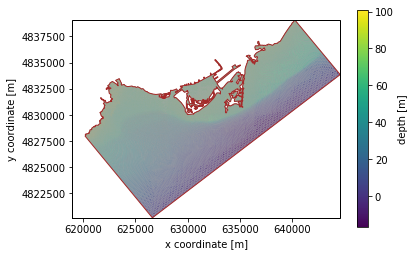

In [4]:
path = r'D:\software\openearthtools\trunk\python\applications\delft3dfm\dflowfmpyplot\test_data'
# build the edges. No return
netcdf_3d3.ugrid.build_edges()

dump = True
if dump:
    [nc_attrs, nc_dims, nc_vars] = netcdf_3d3.nc_dump(verb=True)

triang = tri.Triangulation(lon, lat, triangles=triangles)

# draw the mesh
depth = None
unit = None
bathy = True
projection = cartopy.crs.UTM(zone='17N')
# plot with bathymetry
if bathy:
    variable_name = "flowelem_bl"
    dvar = netcdf_3d3.ugrid.find_uvars_byname(variable_name)
    depth_obj = next(iter(dvar))
    depth = depth_obj.data
    unit = depth_obj.attributes['units']

ax = netcdf_3d3.draw_mesh(projection=projection, triang=triang, depth=depth, unit=unit,
                          numbercontours=25,  contourcolors=['0.5', '0.25', '0.5', '0.5', '0.5'],
                          contourwidths=[0.5, 1.0, 0.5, 0.5, 0.5], refine=2,
                          shpfilename=path + '/' + "lineboundary.shp", blabels=True)

In [ ]:
# now we retrieve four different info from the read nc-file
# - type of grid
# - number of nodes
# - number of faces
# - vertices per face
print(ds.grid.info)

In [ ]:
# the nc-file is a Unstructered Grid with 54925 number of nodes 
# and 53597 number of faces where each face has 4 vertices

In [ ]:
# next, lets check the variables within the dataset"
print("variables available and their standard names:\n")
for name, var in ds.variables.items():
    try:
        print(name, ":", var.attributes['standard_name'])
    except KeyError:
        pass

In [ ]:
# we are interested in the sea surface height:
ssh = ds.variables['mesh2d_waterdepth']

In [ ]:
ssh.attributes

In [ ]:
def days_hours_minutes(td):
    return td.days, td.seconds//3600, (td.seconds//60)%60

# the first and last step of this variable are at?
print("minimum time:", ssh.time.min_time)
print("manimum time:", ssh.time.max_time)
time_arr = ssh.time.get_time_array()
print("timestep (day, hours, minutes):", days_hours_minutes(time_arr[1] - time_arr[0]))

The dataset has nodes (or vertexes) representing a point in a 2D space, the faces (or polygons) correspond to a plane enclosed by a set of edges. Note that the dataset does might not contain the edges! If that is the case ee need to compute those:

In [ ]:
try:
    _ = ssh.grid.edges.shape
    print('edges exist')
    print(_)
except AttributeError:
    print('edges not exist, set first')
    ssh.grid.build_edges()

In [ ]:
start_time = ssh.time.min_time
data = ssh.at(ssh.grid.nodes, start_time)

In [ ]:
data

Let's take a quick look at the mesh.

In [ ]:
# note that we are working with just the variable object now...
lon = ssh.grid.node_lon
lat = ssh.grid.node_lat
faces = ssh.grid.faces
edges = ssh.grid.edges

In [ ]:
LineString(np.stack([lon,lat]).T)

In [ ]:
ssh.grid.get_lines()

In [ ]:
from shapely.geometry import Point, LineString, MultiLineString, Polygon, MultiPolygon

In [ ]:
#LineString([Point(xy[0]),Point(xy[1])])

In [ ]:
lines = []
for xy in ssh.grid.get_lines()[0:3]:
    lines.append(LineString(xy))

In [ ]:
multiline = MultiLineString(lines)

In [ ]:
multiline.convex_hull

In [ ]:
multiline

In [ ]:
ring =  LineString(list(multiline.exterior.coords))

In [ ]:
from shapely import geometry

poly = geometry.Polygon([[p.x, p.y] for p in pointList])

In [ ]:
ssh.grid.get_lines()

In [ ]:
ssh.grid.grid_topology

In [ ]:
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(8, 6),
                           subplot_kw=dict(projection=projection))
    ax.coastlines(resolution='50m')
    gl = ax.gridlines(draw_labels=True)
    gl.xlabels_top = gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [ ]:
# fig, ax = make_map()

# kw = dict(marker='.', linestyle='-', alpha=0.25, color='darkgray')
# ax.triplot(lon, lat, faces, **kw)
# ax.coastlines()
# ax.set_extent([-84, -78, 25, 32])

In [ ]:
fig, ax = plt.subplots(1,1)
ax.plot(lon, lat, 'g')
ax.set_aspect('equal')

In [ ]:
fig, ax = plt.subplots(1,1)
ax.pcolor(lon, lat, vmin=6,  vmax=10)